# Logistic Regression on the Iris Plants Dataset

In this notebook I'm going to quickly run through the Iris Plants Database. Used very frequently in classification exercises and pattern recognition, this classic dataset is clean and has an equal distribution of examples for its three plant classes: Iris-Setosa, Iris-Versicolour, Iris-Virginica. As a general fan of nature, it's always a *thrill* to examine data about plants.

This notebook will contain a brief exploratory visualization between the features in the set, and will then proceed into a hand-made implementation of Logistic Regression. I will also attempt to use the 'Early Stopping' technique to regularize my model.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
% matplotlib inline
from sklearn.datasets import load_iris

## Load and Explore Dataset

In [2]:
data = load_iris()

In [3]:
print(data['DESCR'])

Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)
    ============== ==== ==== ======= ===== ====================

    :Missing Attribute Values: None
  

Reading through summary statistics in the description, we can see that sepal length, petal length, and petal width all have relatively high positive correlations with classifications. There also appears to be a moderate negative correlation with sepal width as well (i.e., smaller sepal widths seem to relate to a certain class).

### Load into Pandas Dataframe

In [4]:
X, y = data['data'], data['target']

In [5]:
full_iris = np.c_[X, y]
full_iris[:5]

array([[ 5.1,  3.5,  1.4,  0.2,  0. ],
       [ 4.9,  3. ,  1.4,  0.2,  0. ],
       [ 4.7,  3.2,  1.3,  0.2,  0. ],
       [ 4.6,  3.1,  1.5,  0.2,  0. ],
       [ 5. ,  3.6,  1.4,  0.2,  0. ]])

In [6]:
iris = pd.DataFrame(full_iris)
iris.columns = ['s_len', 's_wid', 'p_len', 'p_wid', 'class']

In [7]:
iris.head()

,s_len,s_wid,p_len,p_wid,class
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


### Visualize relationships between petal, sepal length/width

### Petal

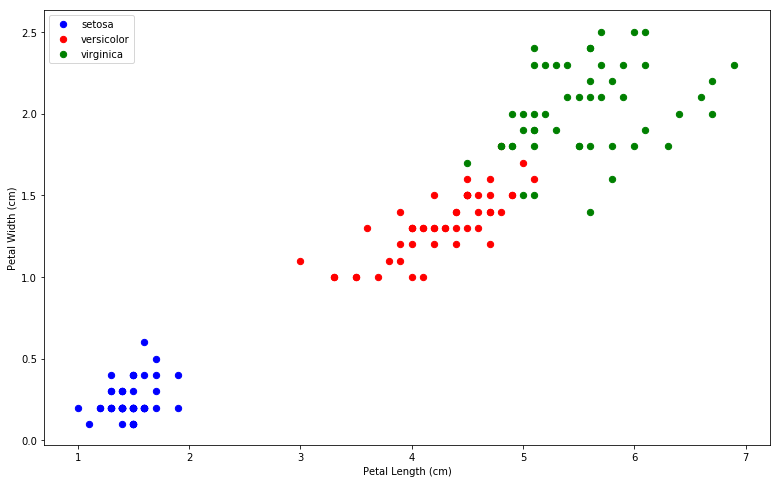

In [8]:
plt.figure(figsize=(13,8))
ax = plt.subplot()
ax.scatter(iris['p_len'].loc[iris['class'] == 0],
           iris['p_wid'].loc[iris['class'] == 0],
           s=40,
           c='b',
           label=data['target_names'][0])

ax.scatter(iris['p_len'].loc[iris['class'] == 1],
           iris['p_wid'].loc[iris['class'] == 1],
           s=40,
           c='r',
           label=data['target_names'][1])

ax.scatter(iris['p_len'].loc[iris['class'] == 2],
           iris['p_wid'].loc[iris['class'] == 2],
           s=40,
           c='g',
           label=data['target_names'][2])

ax.set_xlabel('Petal Length (cm)')
ax.set_ylabel('Petal Width (cm)')
ax.legend(loc='upper left')

Wow! The dimensions of an iris' petal have really clear distinctions on class type. Iris-Setosa has the smallest petals, width lengths no longer than 2 cm and widths maxing out around 0.7 cm. Iris-Setosa is very clearly linearly separable from the other types based solely on petal. Versicolor and Virginica are also pretty distinct, although there is an overlap around petal lengths at 5 cm and widths at 1.5 cm. 

It seems that building a classifier to determine which classes are Setosa would likely result in a high classification accuracy.

### Sepal

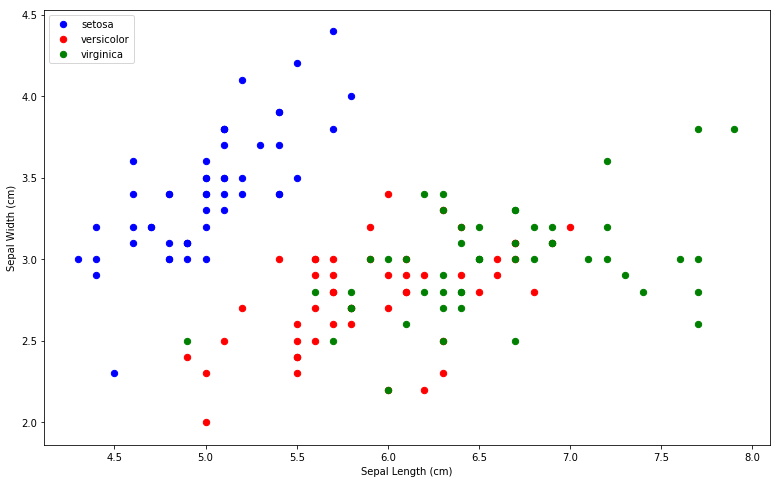

In [9]:
plt.figure(figsize=(13,8))
ax = plt.subplot()
ax.scatter(iris['s_len'].loc[iris['class'] == 0],
           iris['s_wid'].loc[iris['class'] == 0],
           s=40,
           c='b',
           label=data['target_names'][0])

ax.scatter(iris['s_len'].loc[iris['class'] == 1],
           iris['s_wid'].loc[iris['class'] == 1],
           s=41,
           c='r',
           label=data['target_names'][1])

ax.scatter(iris['s_len'].loc[iris['class'] == 2],
           iris['s_wid'].loc[iris['class'] == 2],
           s=40,
           c='g',
           label=data['target_names'][2])

ax.set_xlabel('Sepal Length (cm)')
ax.set_ylabel('Sepal Width (cm)')
ax.legend(loc='upper left')

Once again, it seems as though Iris-Setosa is linearly separable from the other two classes. There is much more overlap in the sepals of Versicolor and Virginica, however.

## Data Preparation for Logistic Regression

### Create Stratified Train and Test Sets

Since the iris dataset is only contains 150 examples, simply doing a random test-train split would result in a high variance of classes in training and test sets. For example, it wouldn't make sense to train a classifer on a set that got almost all of the Iris-Setosa classes and test it against a set that conversely got almost none. The solution is to do a stratified shuffle of the examples by class type and split on that.

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

In [11]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(iris, iris['class']):
    strat_train_set = iris.iloc[train_index]
    strat_test_set = iris.iloc[test_index]

In [12]:
print('training set size: ' + str(len(strat_train_set)))
for x in range(3):
    print(('# of class {} in training set: {}').format(x, (strat_train_set['class'] == x).sum()))

training set size: 120
# of class 0 in training set: 40
# of class 1 in training set: 40
# of class 2 in training set: 40


### Format sets into Numpy Arrays

In [13]:
train_X = strat_train_set.drop('class', axis=1).values
train_X = np.c_[np.ones((len(train_X), 1)), train_X]
train_X[:10]

array([[ 1. ,  4.4,  2.9,  1.4,  0.2],
       [ 1. ,  4.9,  2.5,  4.5,  1.7],
       [ 1. ,  6.8,  2.8,  4.8,  1.4],
       [ 1. ,  4.9,  3.1,  1.5,  0.1],
       [ 1. ,  5.5,  2.5,  4. ,  1.3],
       [ 1. ,  6.3,  2.5,  5. ,  1.9],
       [ 1. ,  5.6,  2.7,  4.2,  1.3],
       [ 1. ,  6.3,  2.8,  5.1,  1.5],
       [ 1. ,  7.7,  3. ,  6.1,  2.3],
       [ 1. ,  7.7,  3.8,  6.7,  2.2]])

In [14]:
test_X = strat_test_set.drop('class', axis=1).values
test_X = np.c_[np.ones((len(test_X), 1)), test_X]
test_X[:10]

array([[ 1. ,  4.4,  3. ,  1.3,  0.2],
       [ 1. ,  6.1,  3. ,  4.9,  1.8],
       [ 1. ,  4.9,  2.4,  3.3,  1. ],
       [ 1. ,  5. ,  2.3,  3.3,  1. ],
       [ 1. ,  4.4,  3.2,  1.3,  0.2],
       [ 1. ,  6.3,  3.3,  4.7,  1.6],
       [ 1. ,  4.6,  3.6,  1. ,  0.2],
       [ 1. ,  5.4,  3.4,  1.7,  0.2],
       [ 1. ,  6.5,  3. ,  5.2,  2. ],
       [ 1. ,  5.4,  3. ,  4.5,  1.5]])

In [15]:
train_y = (strat_train_set['class'] == 2).astype(np.int).values
test_y = (strat_test_set['class'] == 2).astype(np.int).values

In [16]:
train_y

array([0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0])

### Scale Features

In [17]:
### y[x] / y[x.max()]

def scaler(data):
    m, n = data.shape
    scaled_list = []
    for attribute in range(n):
        col = data[:, attribute] / data[:, attribute].max()
        scaled_list.append(col)
    scaled_set = np.array(scaled_list).T
    
    return scaled_set

In [18]:
train_X_scaled = scaler(train_X)
test_X_scaled = scaler(test_X)

### Create initial theta parameter

In [19]:
m, n = train_X.shape
theta = np.zeros((n, 1))

## Implementing Hand-made Logistic Regression

In [20]:
def sigmoid(z):
    return 1/(1 + (np.e)**(-z))

def hypothesis(X, theta):
    return sigmoid(np.dot(X,theta))

def cost_function(theta,X,y):
    m, n = X.shape 
    theta = theta.reshape((n,1))
    y = y.reshape((m,1))
    term1 = np.log(hypothesis(X, theta))
    term2 = np.log(1 - hypothesis(X, theta))
    term1 = term1.reshape((m,1))
    term2 = term2.reshape((m,1))
    term = y * term1 + (1 - y) * term2
    J = -((np.sum(term))/m)
    
    return J

def gradient(theta,X,y):
    m , n = X.shape
    theta = theta.reshape((n,1))
    y = y.reshape((m,1))
    sigmoid_x_theta = sigmoid(X.dot(theta))
    grad = ((X.T).dot(sigmoid_x_theta-y))/m
    return grad

def threshold(hypothesis):
    m = len(hypothesis)
    result = []
    for x in range(m):
        if hypothesis[x] >= 0.5:
            result.append(1)
        else:
            result.append(0)
    result_vector = np.array(result)
    #result_vector = result_vector.reshape((m,1))
    return result_vector

### Batch Gradient Descent for Logistic Regression

def log_bgd(theta, X, y, n_iter=1000, eta=0.1):
    for iteration in range(n_iter):
        theta = theta - (eta * gradient(theta, X, y))
        
    return theta

Let's check to see what the cost function with our initial theta:

In [21]:
cost_function(theta, train_X_scaled, train_y)

0.69314718055994529

Now let's run batch gradient descent to optimize theta:

In [22]:
new_theta = log_bgd(theta, train_X_scaled, train_y)
new_theta

array([[-2.78455178],
       [-0.52070608],
       [-1.69452189],
       [ 2.39621901],
       [ 3.92959938]])

In [23]:
cost_function(new_theta, train_X_scaled, train_y)

0.28360562319264415

Much better! Now let's see the accuracy that these parameters score in the logistic regression:

In [24]:
y_pred = threshold(hypothesis(train_X_scaled, new_theta))
accuracy = (y_pred == train_y).mean()
accuracy

0.97499999999999998

97%! It seems like the model fit the training set almost perfectly. But did it overfit?

## Early Stopping to prevent Overfitting

One way to regularize learning algorithms like Gradient Descent is to stop training as soon as the validation error reaches a minimum. To do this, you cumulatively increase the number of iterations that Gradient Descent takes during training. The accuracy on the training set and validation set will naturally go up over time as the model improves, but the validation set might begin to slightly dip again as it begins to overfit. Early stopping grabs the parameters of the model when the accuracy is at its maximum.

### Create validation set out of previous training set

In [25]:
for new_train_index, val_index in split.split(train_X_scaled, train_y):
    new_train_X = train_X_scaled[new_train_index]
    validation_X = train_X_scaled[val_index]

In [26]:
new_train_y = train_y[new_train_index]
validation_y = train_y[val_index]

In [27]:
new_train.shape, validation_X.shape

NameError: name 'new_train' is not defined

### Early Stopping algorithm

In [ ]:
val_acc = []
train_acc = []

best_accuracy = 0
best_epoch = None
best_model = None
for epoch in range(1000):
    model = log_bgd(theta, new_train_X, new_train_y, n_iter=epoch, eta=0.1)
    y_val_predict = threshold(hypothesis(validation_X, model))
    train_predict = threshold(hypothesis(new_train_X, model))
    
    accuracy = (y_val_predict == validation_y).mean()
    train_accuracy = (train_predict == new_train_y).mean()
    val_acc.append(accuracy)
    train_acc.append(train_accuracy)
    
    if accuracy > best_accuracy:
        print(accuracy)
        best_accuracy = accuracy
        best_epoch = epoch
        best_model = model

In [ ]:
best_accuracy, best_epoch, best_model

Hmmm... It seems that with the smaller training set, the model can fit our mini validation set perfectly! Let's visualize what happened:

In [ ]:
plt.figure(figsize=(13,7))
iterations = np.arange(0, 1000, 1)
ax = plt.subplot()
ax.axis([0, 999, 0, 1.2])
ax.plot(iterations, val_acc, 'r--', label='Validation Set')
ax.plot(iterations, train_acc, 'b-', label='Training Set')
ax.set_title('Accuracy Over Gradient Descent Iterations')
ax.set_xlabel('Gradient Descent Iterations')
ax.set_ylabel('Accuracy')
ax.legend(loc='center', fontsize=14)

We can see that the both the training and validation set accuracy were steadily increasing as the iterations of gradient descent increased. It seems like the fit on the training set is best arond 500 iterations, and then slightly declines towards 600. Around 650 iterations of gradient descent, the validation accuracy plateaued at a perfect score! **Wow!**

Given the small amount of training data we have to work with, it seems as though there isn't any significant overfit on the training set. It doesn't really seem like Early Stopping achieved its intended goal here... Ah well.

## Evaluate on Test Set

Lets evaluate the models we got from our Early Stopping (655 iterations) and Batch Gradient Descent (1000 iterations) and see if there's any real difference.

### Early Stopping

In [ ]:
test_y_pred = threshold(hypothesis(test_X_scaled, best_model))
accuracy = (test_y_pred == test_y).mean()

In [ ]:
cost_function(best_model, test_X_scaled, test_y)

In [ ]:
accuracy

### Batch Gradient Descent

In [ ]:
test_y_pred2 = threshold(hypothesis(test_X_scaled, new_theta))
accuracy2 = (test_y_pred2 == test_y).mean()

In [ ]:
cost_function(new_theta, test_X_scaled, test_y)

In [ ]:
accuracy2

No difference in terms of accuracy! It seems that 650 iterations of Gradient Descent is enough to achieve the best result that a barebones Logistic Regression can muster with these features.

In [ ]:
best_model

In [ ]:
new_theta